In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys

sys.path.insert(1, "/Users/chris/Documents/PhD/ProjectSigma/VelocityDispersion/")
sys.path.insert(1, "/Users/chris/Documents/PhD/ProjectSigma/GalaxyTools")
sys.path.insert(1, "/Users/chris/Documents/PhD/EuclidAGN")
from SigmaLib import Sigma
import AGNCatalogToolbox
from AGNCatalogToolbox.main import stellar_mass_to_black_hole_mass

from Utility import binnedMean
import scipy.io as sio
import scipy.stats as stats
from HM2SM import stellar_mass_to_halo_mass

from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology("planck18")
from colossus.halo import profile_nfw
from colossus.halo import concentration

In [2]:
df = pd.read_csv("/Users/chris/data/MANGa/MANGa.csv")

full_sample = len(df)

print(list(df))

print(full_sample)

df['anisotropy'] = np.ones(full_sample)*0. #np.random.normal(0.3, 0.35, full_sample)


['Unnamed: 0', 'INTID', 'z', 'Total_n', 'BT', 'FLAG_FIT', 'Bulge_n', 'Disk_angle', 'BA_SE_DISK', 'disk_radius', 'bulge_radius', 'full_radius', 'TTYPE', 'P_S0', 'cont', 'Vmax', 'sigma_re', 'bulge_sigma_ap', 'catmasssetrunc', 'catmassstrunc', 'abs_mag', 'sdss_ap_kpc', 'Mstar', 'ap_reduced', 'Sigma_reduced']
1421


In [3]:
halo_mass = stellar_mass_to_halo_mass(df['Mstar'], df['z'], formula="Moster")
halo_mass[halo_mass > 16.5] = 16.5
conc_1 = concentration.concentration((10**halo_mass)*cosmo.h, 'vir', 
                                                df['z'], model = 'ishiyama20')
    
nfw  = profile_nfw.NFWProfile(M = 1E12, c = 10.0, z = 0.0, mdef = 'vir') # Just need the obj
rho, rs = nfw.fundamentalParameters( (10**halo_mass)*cosmo.h, conc_1, df['z'], 'vir')

rs /= cosmo.h
rho *= cosmo.h**2

# Modelling sigma
sigma = Sigma(ApertureSize = df['ap_reduced'],
              Bulge_mass =  np.log10(df['BT'] * (10**df['Mstar'])), 
              Bulge_Re =  df['bulge_radius'], 
              Bulge_n = df['Bulge_n'],
              Bulge_Beta = df['anisotropy'], 
              z = df['z'], 
              Disk_mass = np.log10((1-df['BT'])*((10**df['Mstar']))),
              Disk_inclination = df['Disk_angle'], 
              Disk_scale_length = df['disk_radius'],
              DarkMatter_type='NFW',
              HaloRs = rs,
              HaloRhos = rho,
              debug=True,
              library_path="/Users/chris/Documents/PhD/ProjectSigma/VelocityDispersion/lib/libsigma.so")


halo_mass = stellar_mass_to_halo_mass(df['Mstar'], df['z'], formula="Grylls19")
conc_1 = concentration.concentration((10**halo_mass)*cosmo.h, 'vir', 
                                                df['z'], model = 'ishiyama20')
    
nfw  = profile_nfw.NFWProfile(M = 1E12, c = 10.0, z = 0.0, mdef = 'vir') # Just need the obj
rho, rs = nfw.fundamentalParameters( (10**halo_mass)*cosmo.h, conc_1, df['z'], 'vir')

rs /= cosmo.h
rho *= cosmo.h**2

# Modelling sigma
sigmaG = Sigma(ApertureSize = df['ap_reduced'],
              Bulge_mass =  np.log10(df['BT'] * (10**df['Mstar'])), 
              Bulge_Re =  df['bulge_radius'], 
              Bulge_n = df['Bulge_n'],
              Bulge_Beta = df['anisotropy'], 
              z = df['z'], 
              Disk_mass = np.log10((1-df['BT'])*((10**df['Mstar']))),
              Disk_inclination = df['Disk_angle'], 
              Disk_scale_length = df['disk_radius'],
              DarkMatter_type='NFW',
              HaloRs = rs,
              HaloRhos = rho,
              debug=True,
              library_path="/Users/chris/Documents/PhD/ProjectSigma/VelocityDispersion/lib/libsigma.so")






Length of arrays:  1421
Component array [stars, dark_matter, black_hole]  [1, 1, 0]
Length of arrays:  1421
Component array [stars, dark_matter, black_hole]  [1, 1, 0]


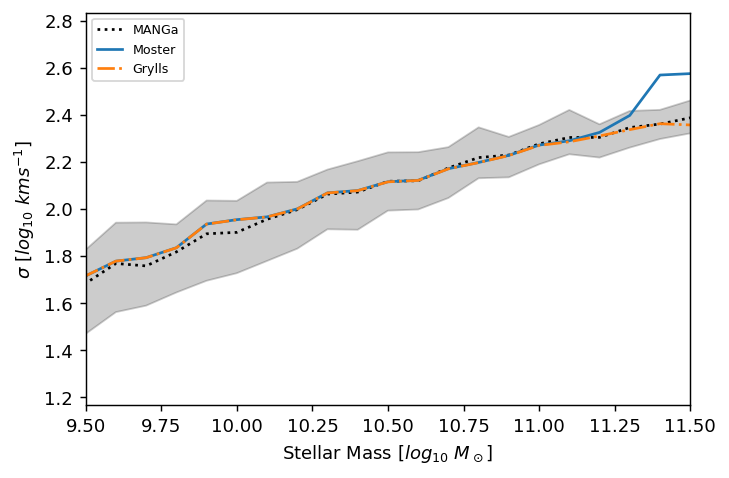

In [6]:
plt.figure(dpi = 130)

bins = np.arange(9, 12.1, 0.1)

# ALL 

###############
array, std_up, std_down = binnedMean(bins, df["Mstar"], df['Sigma_reduced'] , df["Vmax"])
plt.plot(bins[:-1], np.log10(array), ':k', label = "MANGa")
plt.fill_between(bins[:-1],np.log10(array+std_up), np.log10(array-std_down), color = 'black', alpha = 0.2)

array_sim, std_up_sim, std_down_sim = binnedMean(bins, df["Mstar"], sigma , df["Vmax"])
plt.plot(bins[:-1], np.log10(array_sim), '', label = "Moster")

array_sim, std_up_sim, std_down_sim = binnedMean(bins, df["Mstar"], sigmaG , df["Vmax"])
plt.plot(bins[:-1], np.log10(array_sim), '-.', label = "Grylls")


##############

'''
# Ellipticals
####################
Ellipticals_mask = ((df['TTYPE'] > -8) & (df['TTYPE'] < 0) & (df['P_S0'] < 0.5))

per = 100*np.sum(Ellipticals_mask)/full_sample

array, std_up, std_down = binnedMean(bins, df["Mstar"][Ellipticals_mask], 
                                     df['Sigma_reduced'][Ellipticals_mask], 
                                     df["Vmax"][Ellipticals_mask])
plt.plot(bins[:-1], np.log10(array), ':r')
array_sim, std_up_sim, std_down_sim = binnedMean(bins, df["Mstar"][Ellipticals_mask], 
                                                 sigma[Ellipticals_mask] , 
                                                 df["Vmax"][Ellipticals_mask])
plt.plot(bins[:-1], np.log10(array_sim), 'r', label = "Ellipticals {:.2f}%".format(per))
'''
"""
####################

# S0s
####################
S0_mask = ((df['TTYPE'] > -8) & (df['TTYPE'] < 0) & (df['P_S0'] > 0.5))

per = 100*np.sum(S0_mask)/full_sample

array, std_up, std_down = binnedMean(bins, df["Mstar"][S0_mask], 
                                     df['Sigma_reduced'][S0_mask], 
                                     df["Vmax"][S0_mask])
plt.plot(bins[:-1], np.log10(array), ':b')
array_sim, std_up_sim, std_down_sim = binnedMean(bins, df["Mstar"][S0_mask], 
                                                 sigma[S0_mask] , 
                                                 df["Vmax"][S0_mask])
plt.plot(bins[:-1], np.log10(array_sim), 'b', label = "S0s {:.2f}%".format(per))
####################

# Spirals
####################
Sprial_mask = (df['TTYPE'] > 0)

per = 100*np.sum(Sprial_mask)/full_sample

array, std_up, std_down = binnedMean(bins, df["Mstar"][Sprial_mask], 
                                     df['Sigma_reduced'][Sprial_mask], 
                                     df["Vmax"][Sprial_mask])
plt.plot(bins[:-1], np.log10(array), ':g')
array_sim, std_up_sim, std_down_sim = binnedMean(bins, df["Mstar"][Sprial_mask], 
                                                 sigma[Sprial_mask] , 
                                                 df["Vmax"][Sprial_mask])
plt.plot(bins[:-1], np.log10(array_sim), 'g', label = "Sprials {:.2f}%".format(per))
####################
"""



plt.legend(fontsize = 7)

plt.xlim([9.5, 11.5])

plt.xlabel(r"Stellar Mass [$log_{10}$ $M_\odot$]")
plt.ylabel(r"$\sigma$ [$log_{10}$ $kms^{-1}$]")

plt.savefig("/Users/chris/Desktop/FullCat.png")

plt.show()

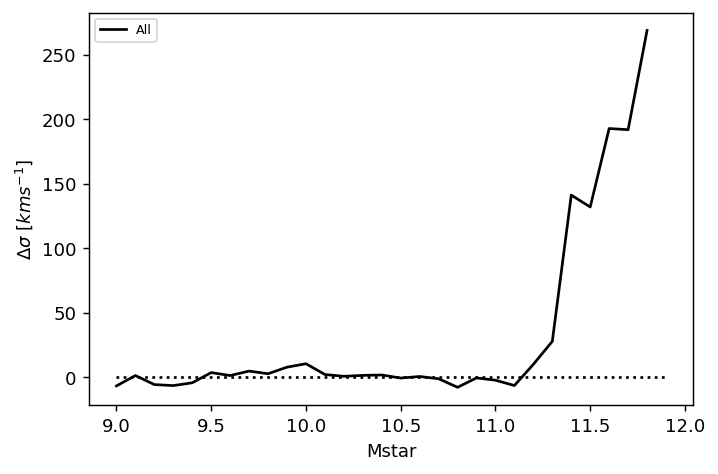

In [5]:
plt.figure(dpi = 130)


binned_var_name = 'Mstar'
bins = np.arange(9, 12, 0.1)

# ALL 
###############
array, std_up, std_down = binnedMean(bins, df[binned_var_name], df['Sigma_reduced'] , df["Vmax"])
array_sim, std_up_sim, std_down_sim = binnedMean(bins, df[binned_var_name], sigma , df["Vmax"])

residual = array_sim - array

plt.plot(bins[:-1], residual, 'k', label = "All")
##############
"""
# Ellipticals
###############
Ellipticals_mask = (df['Mstar'] > 11)
array, std_up, std_down = binnedMean(bins, df[binned_var_name][Ellipticals_mask], 
                                     df['Sigma_reduced'][Ellipticals_mask] , 
                                     df["Vmax"][Ellipticals_mask])
array_sim, std_up_sim, std_down_sim = binnedMean(bins, df[binned_var_name][Ellipticals_mask], 
                                                 sigma[Ellipticals_mask] , df["Vmax"][Ellipticals_mask])

residual = array_sim - array

plt.plot(bins[:-1], residual, 'b', label = ">11")
##############

# Spirals
###############
Ellipticals_mask = (df['Mstar'] < 11)
array, std_up, std_down = binnedMean(bins, df[binned_var_name][Ellipticals_mask], 
                                     df['Sigma_reduced'][Ellipticals_mask] , 
                                     df["Vmax"][Ellipticals_mask])
array_sim, std_up_sim, std_down_sim = binnedMean(bins, df[binned_var_name][Ellipticals_mask], 
                                                 sigma[Ellipticals_mask] , df["Vmax"][Ellipticals_mask])

residual = array_sim - array

plt.plot(bins[:-1], residual, 'r', label = "<11")
##############
"""

plt.plot([bins[0], bins[-1]], [0, 0], ':k' )

plt.legend(fontsize = 7)

plt.xlabel(binned_var_name)
plt.ylabel(r"$\Delta\sigma$ [$kms^{-1}$]")

plt.show()